<a href="https://colab.research.google.com/github/a3ulez/PHOIBLE/blob/master/AI_Generated_Art_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖌 AI_Generated Art Detector 🔍
This notebook uses TensorFlow 2.18.0 and Tensor Hub to train a model to detect AI-generated artwork for companies testing the legitimacy of commissioned work.

##Problem
Wide availability of AI-powered models and online art has powered thieves to take others' work without permission to sell artwork generated by AI as their own work, endangering the financial stability of current artists as well as the future of unique human expression and online intercultural communication through art. Companies that want to support human artists need tools to help them recognize when AI-generated art has been marketed to or through them and help them make ethical business decisions.

##Data
The model was trained from this dataset available at Kaggle.com: https://www.kaggle.com/datasets/superpotato9/dalle-recognition-dataset/

##Evaluation
Target 90% accuracy of labeling art as human or AI-generated

##Features
Unstructured data :. best to learn deep learning / transfer learning
No data file is provided for the image ids or classification and must be created
Images in .jpg format in two classes:
  Human-Generated - 3,781
  AI-Generated - 17,857


In [1]:
!pip install --upgrade tensorflow==2.18.0
!pip install --upgrade tensorflow_hub

import tensorflow as tf
from tensorflow import keras as tfk
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import datetime
import kagglehub
import tensorflow_hub as hub

##Unzip Data

In [2]:
fp = "/content/drive/MyDrive/AI_Art_Detector/archive.zip"
dest = "/content/drive/MyDrive/AI_Art_Detector"

#with zipfile.ZipFile(fp, 'r') as zip_ref:
#    zip_ref.extractall(dest)

##Get Data Ready
###Make CSV of Image Names as IDs with Boolean Labels
Get names of files as IDs and paths then create a list of all for reference

In [3]:
#Ignoring PNGs and other non-image files
valid_exts = {'.jpg', '.jpeg'}

real_path = "/content/drive/MyDrive/AI_Art_Detector/real"
real_set = os.listdir(real_path)
fake_path = "/content/drive/MyDrive/AI_Art_Detector/fakeV2/fake-v2"
fake_set = os.listdir(fake_path)

real_files = [os.path.splitext(item)[0]
    for item in real_set
    if os.path.isfile(os.path.join(real_path, item)) and os.path.splitext(item)[1].lower() in valid_exts]

fake_files = [(os.path.splitext(item)[0]+"6610")
    for item in fake_set
    if os.path.isfile(os.path.join(fake_path, item)) and os.path.splitext(item)[1].lower() in valid_exts]

real_paths = [os.path.join(real_path, item)
    for item in real_set
    if os.path.isfile(os.path.join(real_path, item)) and os.path.splitext(item)[1].lower() in valid_exts]

fake_paths = [os.path.join(fake_path, item)
    for item in fake_set
    if os.path.isfile(os.path.join(fake_path, item)) and os.path.splitext(item)[1].lower() in valid_exts]

all_paths = real_paths + fake_paths

####Send Filenames to CSVs
Create dataframes with image name as ID and boolean Class
Boolean: 1 = human-made (real) and 0 = AI-generated (not real)

In [4]:
real_df = pd.DataFrame({"id": real_files, "class": 1, "path": real_paths})
fake_df = pd.DataFrame({"id": fake_files, "class": 0, "path": fake_paths})

#Even out sample sizes of AI and Human art
fake_df_shuffled = fake_df.sample(frac=1, random_state=11)
fake_df_trimmed = fake_df_shuffled.drop(fake_df_shuffled.index[3638:],inplace=False)

#Combine real and fake sets
all_images_df = pd.concat([real_df,fake_df])
even_df = pd.concat([real_df,fake_df_trimmed])

#Shuffle order of images in list to ensure more even sample in train, test groups
even_shuffled_df = even_df.sample(frac=1, random_state=11)

"""
even_shuffled_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/even_shuffled.csv")
real_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/real_id_class.csv")
fake_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/fake_id_class.csv")
all_images_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/all_id_class.csv")
"""

'\neven_shuffled_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/even_shuffled.csv")\nreal_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/real_id_class.csv")\nfake_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/fake_id_class.csv")\nall_images_df.to_csv("/content/drive/MyDrive/AI_Art_Detector/all_id_class.csv")\n'

###Split Data into Train, Validate, Test Sets

In [5]:
#Set Number of Images to Use for Experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min: 100, max: 7000, step: 1000}

#Reset indices to avoid repeates
even_shuffled_df = even_df.sample(frac=1, random_state=11).reset_index(drop=True)

# Now safely select first NUM_IMAGES
x = even_shuffled_df['id'][:NUM_IMAGES]
y = even_shuffled_df['class'][:NUM_IMAGES]
z = even_shuffled_df['path'][:NUM_IMAGES]

from sklearn.model_selection import train_test_split

#First split into training (80%) Temp (20%)
z_train, z_temp, y_train, y_temp = train_test_split(z[:NUM_IMAGES],
                                                    y[:NUM_IMAGES],
                                                    test_size=0.2,
                                                    random_state=11)

#Then split Temp into Validate (10%) and Test (10%)
z_val, z_test, y_val, y_test = train_test_split(z_temp,y_temp,
                                                test_size=0.5,
                                                random_state=11)

###Process Images

####Function to Process Images

In [6]:
IMG_SIZE = 224

#Function definition
def process_img(img_path):
  """
  Takes an image path and process the image into a 3-channel RGB tensor,
  resizes it to a square of s = IMG_SIZE,
  and returns the tensor
  """
  #Read in image file
  image = tf.io.read_file(img_path)

  #Turn jpg into a Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)

  #Normalize color channel values
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize image
  image = tf.image.resize(image, size=[IMG_SIZE,IMG_SIZE])

  return image

####Batches of Tensors

In [7]:
#Function to return data in a tuple: id, class

def get_img_class_tuple(img_path,img_class):
  """
  Takes an image path and sends it to the process_img function.
  Returns a tuple with (image, classification)
  """
  image = process_img(img_path)
  return image, img_class

In [8]:
#Get data into batches
BATCH_SIZE = 32

In [9]:
#Function to put data in batches
def create_batches(x, y=None, batch_size = BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches out of image filepaths(x) and labels(y)
  Shuffles data (unless it's for the validation split)
  No labels for test data split
  """
  if test_data:
    print("Creating test data batch")
    #Tensors with just image filepaths(x)
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    #Process images and create batch
    data_batch = data.map(process_img).batch(BATCH_SIZE)
    return data_batch

  if valid_data:
    print("Creating validation data batch")
    #Tensors with filepaths(x) and labels(y)
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))
    #Process data and create batch
    data_batch = data.map(get_img_class_tuple).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batch")
    #Turn filepaths into tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    #Shuffle filepaths and labels
    data = data.shuffle(buffer_size=len(x))
    #Process data and create batch
    data_batch = data.map(get_img_class_tuple).batch(BATCH_SIZE)
    return data_batch


##Create Data Batches

In [10]:
#Training Data
training_data = create_batches(z_train,y_train)
val_data = create_batches(z_val,y_val, valid_data=True)


Creating training data batch
Creating validation data batch


###Visualize Data

In [11]:
def show_25_images(images,labels):
  """
  Display plot of 25 images with labels
  """
  plt.figure(figsize=(10,10))
  #Loop through images
  for i in range(25):
    ax = plt.subplot(5,5,i+1)
    #Display an image
    plt.imshow(images[i])
    #Add image classification as title
    title = labels[i]
    plt.title(title)
    plt.axis("off")


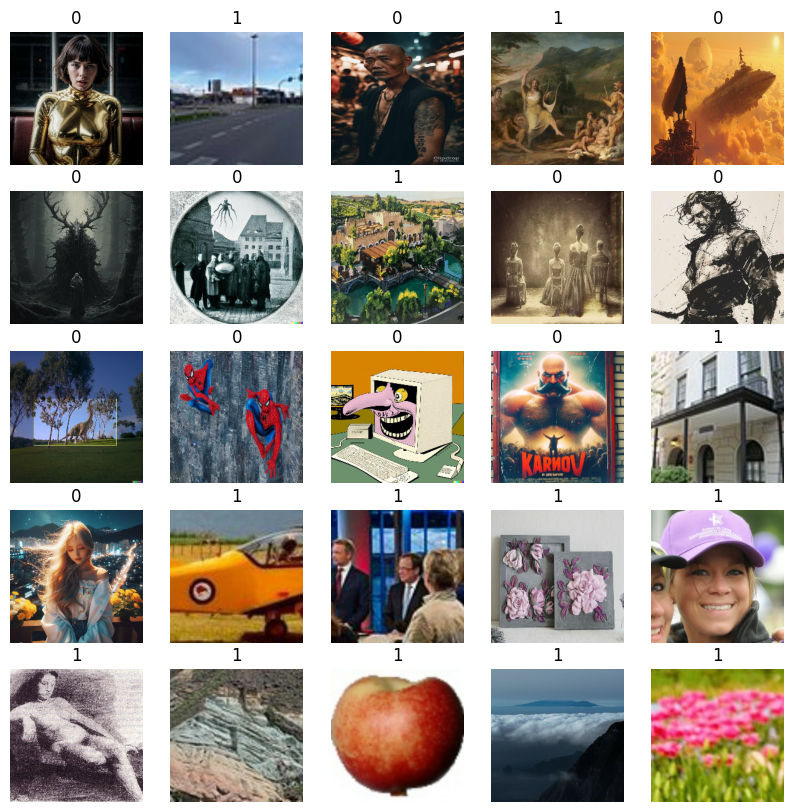

In [17]:
"""
training_images, training_labels = next(training_data.as_numpy_iterator())
show_25_images(training_images,training_labels)
"""

##Build Training Model

In [29]:
import tensorflow as tf
from tensorflow import keras as tfk
import tensorflow_hub as hub

IMG_SIZE = 224

def create_model():
    print("Building model")

    # Input layer
    input_layer = tfk.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name="input_image")

    # Load feature extractor directly from TF Hub
    feature_extractor = hub.KerasLayer(
        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
        trainable=True,
        name="mobilenet_feature_extractor"
    )

    # Extract features from image
    x = feature_extractor(input_layer)
    x = tfk.layers.Dropout(0.3)(x)
    output = tfk.layers.Dense(1, activation='sigmoid', name="output")(x)

    model = tfk.Model(inputs=input_layer, outputs=output)

    model.compile(
        loss=tfk.losses.BinaryCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model


In [26]:
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    trainable=True,
    name="mobilenet_feature_extractor"
)


In [27]:
def create_model():
    print("Building model")

    # Load feature extractor from TF Hub directly with input shape
    feature_extractor = hub.KerasLayer(
        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        trainable=True,
        name="mobilenet_feature_extractor"
    )

    # Build the model
    model = tfk.Sequential([
        feature_extractor,
        tfk.layers.Dropout(0.3),
        tfk.layers.Dense(1, activation='sigmoid', name="output")
    ])

    model.compile(
        loss=tfk.losses.BinaryCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model

In [30]:
model = create_model()
model.summary()

Building model


ValueError: Exception encountered when calling layer 'mobilenet_feature_extractor' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'mobilenet_feature_extractor' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=input_image>
  • training=None

##Evaluate Model

In [ ]:
"""
#Function to build TensorBoard callback
def create_tensorboard_callback():
	#Log directory to store Tensorboard logs
  logdir = os.path.join("/content/drive/MyDrive/AI_Art_Detector/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

  return tfk.callbacks.TensorBoard(log_dir=logdir)
"""

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

##Training on Subset of Data

In [ ]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step:10}

In [ ]:
#Function to train model
def train_model():
  """
  Trains model and returns the trained version
  """
  model = create_model()

  # Fit the model and store the training history
  history = model.fit(
      x=training_data,
      epochs=NUM_EPOCHS,
      validation_data=val_data,
      callbacks=[early_stopping])


  # Print last epoch's val accuracy
  print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
  print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

  return model

In [ ]:
#Fit model to the data
model = train_model()